# Question 2
## Submitted by:
1.   Bhupinder Singh (ID: 10634583)
2.   Jaswanth Reddy Mali (ID: 10638130)
3. Linga Reddy Mamidi (ID: 10635793)


The following code mounts google drive with Colab so that COlab can access files stored in google drive. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image classification using CNN

The code below imports the libraries required for TensorFlow deep learning model development and training, as well as Matplotlib and PIL (Python Imaging Library) data visualisation. In particular, it imports the TensorFlow library for running the computations on GPUs, the Keras API for creating and training deep learning models, and the NumPy library for numerical computations.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

The following code declares the values of all of the constant terms involved in the computation. Here, we have used a reduced dimensions of image to 360 by 480 pixels instead of 1200 by 1600 pixels because colab kept crashing due to shortage of RAM.

In [3]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 360
IMAGE_WIDTH = 480
CHANNELS=3
EPOCHS=10

For our model, we downloaded the data and stored in google drive. We have used the following code to extract training dataset from the whole dataset. It splits the data into 80% and 20%. The subset = "training" makes sure that training data (80%) is extracted.


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/MLPR",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

Found 1899 files belonging to 5 classes.
Using 1520 files for training.


The following line of code extracts validation dataset from the dataset. The subset = "validation" makes sure that validation data (20%) is extracted.

In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/MLPR",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

Found 1899 files belonging to 5 classes.
Using 379 files for validation.


The training dataset's class names are printed by the code that follows. The TensorFlow Keras API's image_dataset_from_directory() method, which automatically deduces the class names from the subdirectories of the directory supplied as a parameter, is expected to have been used to construct the dataset object called train_ds. 

In [6]:
class_names = train_ds.class_names
print(class_names)

['Product_1', 'Product_2', 'Product_3', 'Product_4', 'Product_5']


Using Matplotlib, the following code runs through the first nine photos in the first batch of images and labels from the training dataset (train_ds.take(1)). It creates a subplot in a 3 by 3 grid for each image, uses imshow() to display the images.

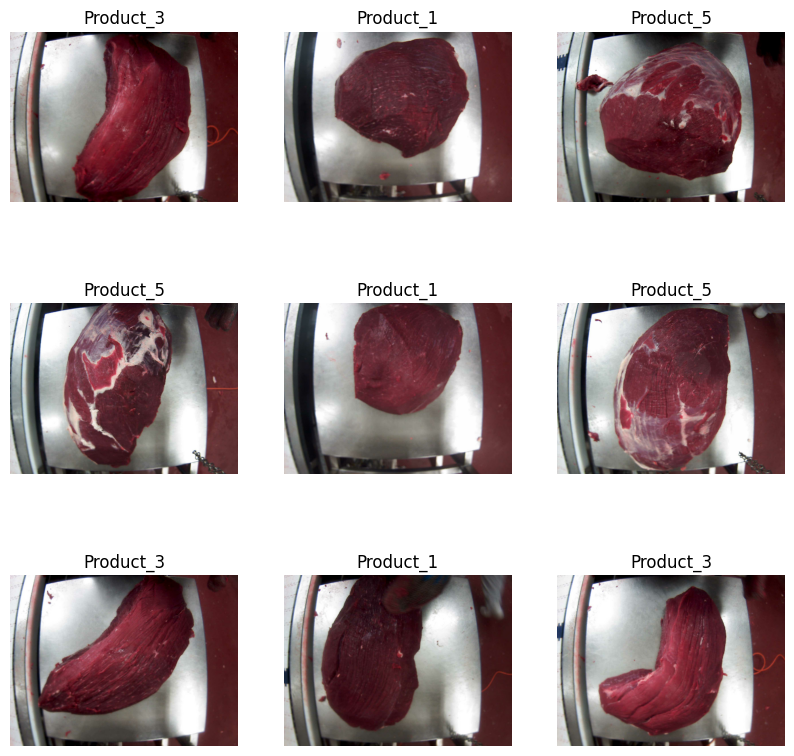

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The following code loops through the batches of labels and images in the training dataset (train_ds), printing the form of the label and image tensors for each batch and iterating over the batches. This makes sure that the input data is in the required shape.

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 480, 3)
(32,)


The AUTOTUNE parameter is set to the value of tf.data by the code that follows.TensorFlow can automatically tweak the best value for some parameters during training thanks to the AUTOTUNE feature. The training dataset is subsequently subjected to caching and shuffling, which randomly shuffles the data and stores it in memory to speed up training. Last but not least, it prefetches the data from disc or RAM, enabling the data to be loaded concurrently with model training and speeding up training. To boost performance, the validation dataset is also prefetched and cached.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

The Rescaling class from the Keras API is used in the following code to generate a normalisation layer. By multiplying each pixel value by 1./255, the layer is used to rescale the input images' pixel values to the range [0, 1]. 

In [10]:
normalization_layer = layers.Rescaling(1./255)


The normalisation layer (normalization_layer) is applied to the training dataset (train_ds) using the dataset object's map() method in the code below. The map() method assigns a specific function to each dataset piece. Each image in the dataset is given a normalisation layer using the lambda function in this instance, and the associated label is kept. The first batch of normalised images and labels are then extracted from the resulting dataset by iterating over it using the next() and iter() functions. Following normalisation, the pixel values of the first image in the batch are printed to the console to confirm that they are in the required range [0,1].

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


Using the Keras API, the following code defines a sequential model. A normalisation layer (Rescaling), numerous convolutional layers (Conv2D), pooling layers (MaxPooling2D), a flatten layer (Flatten), and several fully connected layers (Dense) comprise the model. The model's input shape is defined as (IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS). The length of the class_names list is used to determine the number of output classes (num_classes).

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

The code below compiles the sequential model (model) using the Keras API. The compile() method defines the optimizer, loss function, and evaluation metrics to be utilised during training. The optimizer is set to Adam, which is a common deep learning optimizer. The loss function is SparseCategoricalCrossentropy, which is often used for multiclass classification tasks. The from_logits=True parameter indicates that the model outputs are not normalised probabilities, but raw logits. The accuracy metric is also defined for evaluation during training.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

The following code outputs a list of the model's layer types, output shapes, and parameter counts.



In [14]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 360, 480, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 360, 480, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 180, 240, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 240, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 120, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 120, 64)       1

The following code trains the compiled model (model) using the fit() method with the training dataset (train_ds) and validation dataset (val_ds) as inputs. 

In [15]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/10
48/48 [==============================] - 100s 2s/step - loss: 1.2069 - accuracy: 0.6230 - val_loss: 0.4358 - val_accuracy: 0.8470
Epoch 2/10
48/48 [==============================] - 5s 98ms/step - loss: 0.2963 - accuracy: 0.9026 - val_loss: 0.2135 - val_accuracy: 0.9446
Epoch 3/10
48/48 [==============================] - 5s 97ms/step - loss: 0.1626 - accuracy: 0.9539 - val_loss: 0.1332 - val_accuracy: 0.9710
Epoch 4/10
48/48 [==============================] - 5s 103ms/step - loss: 0.1063 - accuracy: 0.9586 - val_loss: 0.1239 - val_accuracy: 0.9578
Epoch 5/10
48/48 [==============================] - 5s 98ms/step - loss: 0.0546 - accuracy: 0.9829 - val_loss: 0.1372 - val_accuracy: 0.9657
Epoch 6/10
48/48 [==============================] - 5s 98ms/step - loss: 0.0289 - accuracy: 0.9954 - val_loss: 0.1722 - val_accuracy: 0.9393
Epoch 7/10
48/48 [==============================] - 5s 100ms/step - loss: 0.0419 - accuracy: 0.9868 - val_loss: 0.1629 - val_accuracy: 0.9472
Epoch 8/10


The following code gives a graphical representation of the history of accuracies over all epochs for training and validation datasets. From the graph, it can be noted that the there is a gap between accuracy of validation dataset and accuracy of training dataset. This gap in accuracy generally indicates presence of overfitting. Therefore, we have tried to improve the model even further with the help of data augmentation which basically generates additional training documents by rotating, zooming, flipping the current image files. 

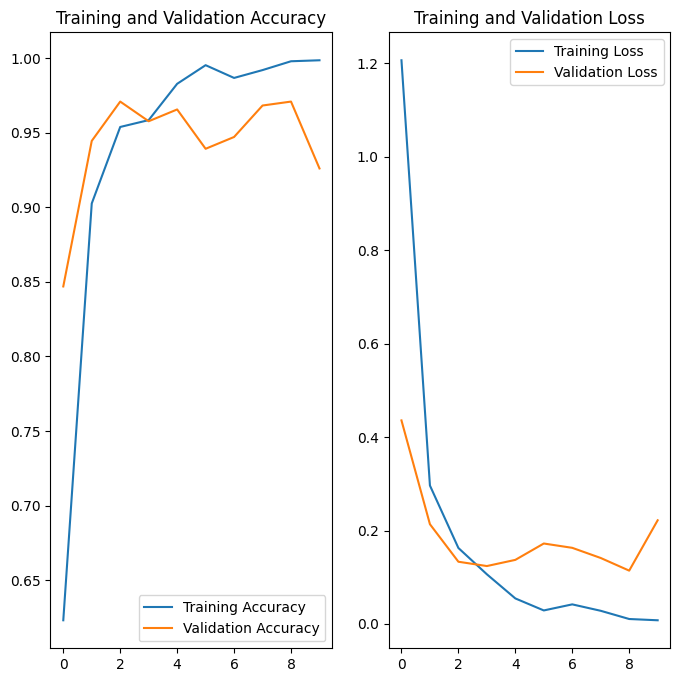

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The following code creates a Sequential model (data_augmentation) that during training randomly rotates, zooms, and flips the input images horizontally (RandomFlip, RandomRotation). The purpose is to generate additional data instances for even better training and better accuracies at the end. 

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_HEIGHT,
                                  IMAGE_WIDTH,
                                  CHANNELS)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

The following code prints some of the augmented images which will be used to train the model. 

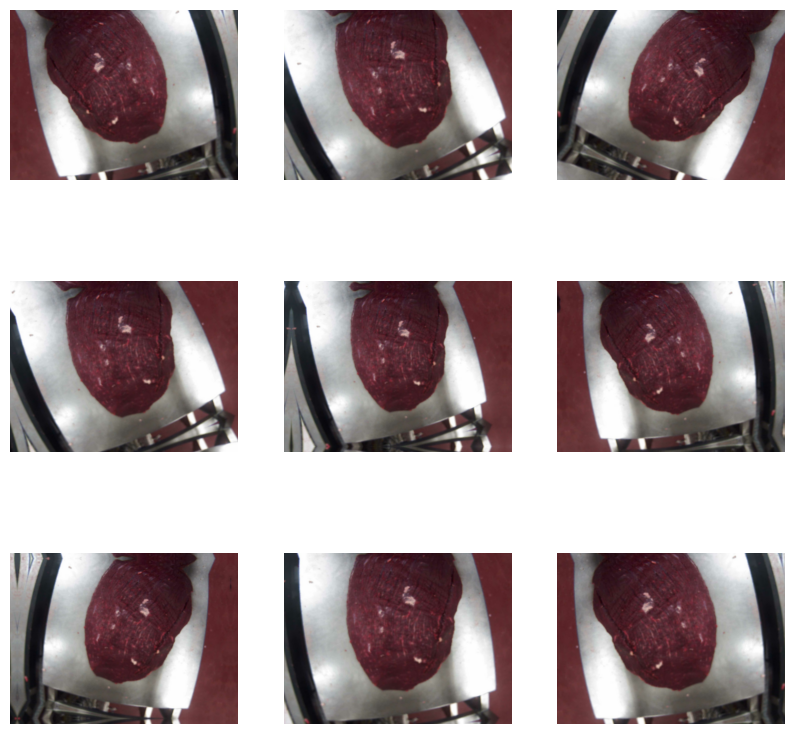

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.axis("off")

The following sequential model is similar to the previous model with a difference that data augmentation layer is added now and a dropout layer is added. The dropout layer prevents overfitting by randomly dropping out a fraction of inputs. Here 0.2 means 20% of the images are randomly dropped to prevent overfitting of the model. 

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

This following code compiles a Keras sequential model with the Adam optimizer, sparse categorical cross-entropy as the loss function and accuracy as the metric to be used during training and evaluation.

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

The following code generates summary of the model including layers, output shapes and parameters.

In [23]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 360, 480, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 360, 480, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 360, 480, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 180, 240, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 240, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 120, 32)      0         
 2D)                                                  

In [24]:
history_CNN = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/10
48/48 [==============================] - 10s 165ms/step - loss: 1.3542 - accuracy: 0.5664 - val_loss: 0.4375 - val_accuracy: 0.8681
Epoch 2/10
48/48 [==============================] - 8s 159ms/step - loss: 0.3701 - accuracy: 0.8796 - val_loss: 0.4295 - val_accuracy: 0.8602
Epoch 3/10
48/48 [==============================] - 8s 157ms/step - loss: 0.2923 - accuracy: 0.9039 - val_loss: 0.2822 - val_accuracy: 0.9103
Epoch 4/10
48/48 [==============================] - 8s 157ms/step - loss: 0.2184 - accuracy: 0.9263 - val_loss: 0.1392 - val_accuracy: 0.9551
Epoch 5/10
48/48 [==============================] - 8s 157ms/step - loss: 0.2308 - accuracy: 0.9197 - val_loss: 0.1404 - val_accuracy: 0.9578
Epoch 6/10
48/48 [==============================] - 8s 160ms/step - loss: 0.1962 - accuracy: 0.9316 - val_loss: 0.1697 - val_accuracy: 0.9604
Epoch 7/10
48/48 [==============================] - 7s 155ms/step - loss: 0.1644 - accuracy: 0.9493 - val_loss: 0.1109 - val_accuracy: 0.9736
Epoch

The following code prints the accuracy during last epoch for training dataset

In [25]:
history_CNN.history["accuracy"][-1]

0.9559210538864136

The following code prints the accuracy during last epoch for validation dataset

In [26]:
history_CNN.history["val_accuracy"][-1]

0.9630606770515442

The following code gives a graphical representation of the history of accuracies over all epochs for training and validation datasets. Now, the difference between accuracies or the gap between accuracies is lesser indicating a more robust or reliable model.

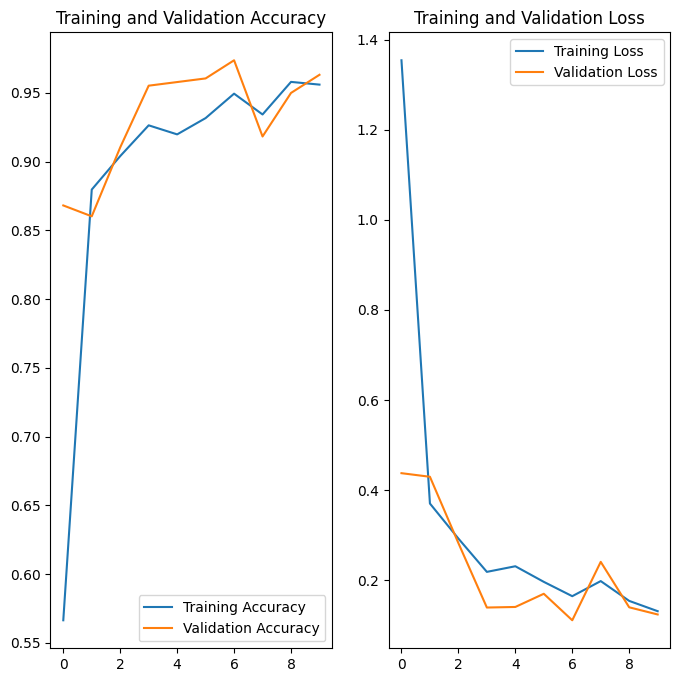

In [27]:
acc = history_CNN.history['accuracy']
val_acc = history_CNN.history['val_accuracy']

loss = history_CNN.history['loss']
val_loss = history_CNN.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Image classification using Transfer Learning
A model that has been trained for one task is repurposed or converted to a new, but similar task using the machine learning process known as transfer learning. Transfer learning involves applying what has been learnt from the source task to the target task. This might help the model perform better on the target task, especially if there is a dearth of training data for the target task.



In [28]:
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The code that follows sets up the TensorBoard visualisation tool and imports various Python libraries, including numpy, PIL, matplotlib, tensorflow, and tensorflow_hub. Additionally, a function is defined for loading a pre-trained model from TensorFlow Hub, which may be applied to a variety of machine learning tasks. The pre-trained model is then used to build a feature vector for the image, which is subsequently displayed alongside the loaded image in the code. Finally, TensorBoard logging is configured, and the feature vector is written to a log file for analysis and visualisation.

In [29]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

Two variables, mobilenet_v2 and inception_v3, which are defined in the code and hold the URLs to pre-trained image classification models stored on TensorFlow Hub, are also included. Next, the value of the classifier_model variable is set to mobilenet_v2, indicating that any further code will classify images using the MobileNet V2 model.

In [30]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

The pre-trained image classification model given by classifier_model loaded from TensorFlow Hub, which accepts an input image with shape (224, 224, 3), is used to generate a tf.keras.Sequential model with a single layer in the following code.


In [31]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

The following code declares the values of the constants to be used in the code. 

In [32]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

For our model, we downloaded the data and stored in working directory of jupyter with the name "MLPR Images". We have used the following code to extract training dataset from the whole dataset. It splits the data into 80% and 20%. The subset = "training" makes sure that training data (80%) is extracted.

In [33]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/MLPR",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)


Found 1899 files belonging to 5 classes.
Using 1520 files for training.


The following line of code extracts validation dataset from the dataset. The subset = "validation" makes sure that validation data (20%) is extracted.

In [34]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/MLPR",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

Found 1899 files belonging to 5 classes.
Using 379 files for validation.


The code below creates a variable called "class_names" and assigns it an array containing the class names of the training dataset "train_ds." The function "np.array" is used to generate a NumPy array from the class names. Finally, the class names are displayed using the "print" method.



In [35]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Product_1' 'Product_2' 'Product_3' 'Product_4' 'Product_5']


The following code defines a normalisation layer using tf.keras.layers.To scale the pixel values of photos in the dataset between 0 and 1, use the rescaling function. The normalisation layer is then applied to each image in the dataset using the train_ds and val_ds datasets.



In [36]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

The code below defines a constant variable AUTOTUNE, whose value allows TensorFlow to automatically tune the ideal number of input items to process in parallel. After that, the train_ds and val_ds datasets are cached and prefetched with an AUTOTUNE buffer size, allowing for faster data loading during training.



In [37]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

The code below iterates over the train_ds dataset, displaying the shape of the picture and label batches for each iteration. The break statement is used to terminate the loop after the first iteration.


In [38]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


The code below downloads a file named "ImageNetLabels.txt" from a provided URL and saves it in the "labels_path" variable using the tf.keras.utils.get_file method. The contents of the file are then read and split into lines, which are then turned into a NumPy array named "imagenet_labels."


In [39]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


The code below predicts the class probabilities for the whole train_ds dataset using the trained classifier model, and stores the resultant batch of predictions in the result_batch variable.


In [40]:
result_batch = classifier.predict(train_ds)


48/48 [==============================] - 13s 217ms/step


The code below use the tf.math.argmax function to get the class index with the highest predicted probability for each image in the result_batch. The index is then used to hunt up the relevant class name in the imagenet_labels array, and the predicted class names are saved in the predicted_class_names variable.

In [41]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['cleaver', 'breastplate', 'butcher shop', ..., 'rotisserie',
       'breastplate', 'stole'], dtype='<U30')

The following code iterates through the first 30 images and their predicted class names using a for loop and plt.subplot, displaying each image and its corresponding class name. But, these class names are not required by us. These class names belong to mobilenet_v2. Later on, we are going to remove the class names and add a new classification layer defined by us. 

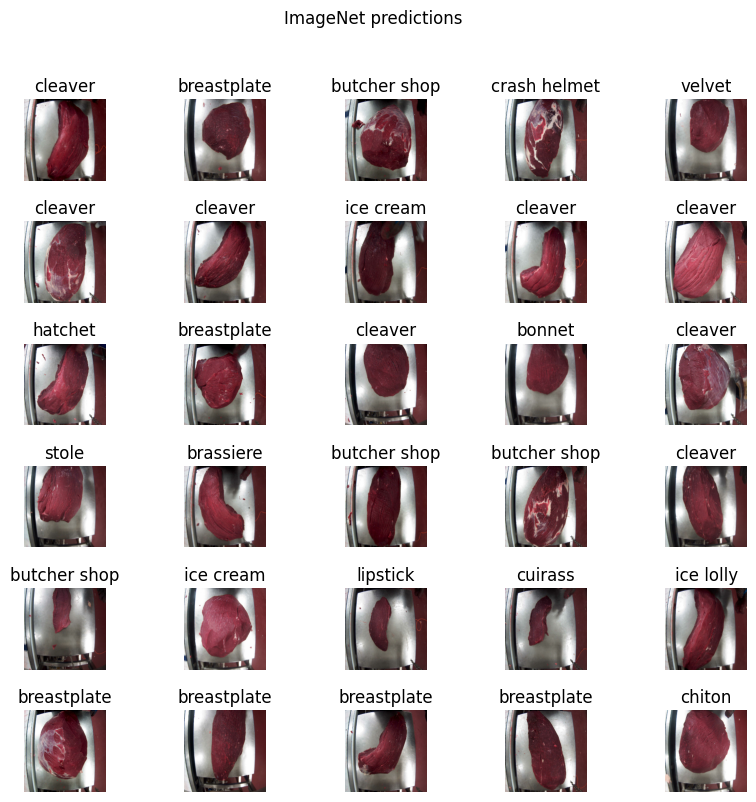

In [42]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In the previous ouput, It can be noted that the classication is performed, but the classification layer is not as per our requirement. It is not categorized as product_1 or product_2 and thus. The mobilenet_v2 is using its own classification layer which has to be removed so that we can apply our own defined classification layer which has classifiers defined by us. 

The following code selects mobilenet_v2 as the feature extractor model to be used in the following code. This code is basically extracting model without the top classification layer. Simply, we are extracting a headless model. In transfer learning, a headless model is a pre-trained model that includes all layers up to the output layer but without the final classification layer. This suggests that the headless model has already learned to extract significant features from input data, but it has yet to learn to categorise the data. The classification layer will be added by us and the classification layer will have five categories only: Product_1,Product_2, Product_3, Product_4 and Product_5

In [43]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

The code below produces a KerasLayer object with the supplied feature_extractor_model URL as the pre-trained model to be used as a feature extractor. The input_shape parameter sets the expected shape of the input images, and trainable=False disables updating the weights of the pre-trained layers during training.

In [44]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

This following code passes a batch of images image_batch through the feature_extractor_layer to extract features from them using the pre-trained model specified in feature_extractor_model. The resulting features are stored in feature_batch, and print(feature_batch.shape) outputs the shape of feature_batch.

In [45]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


The following code defines a Sequential model that has pretrained layer named "feature_extractor_layer" and a new layer having argument "num_classes". That new layer is used to classify the images into different categories. Then the summary of the model is generated to know layers, outputshapes and number of trainable parameters. 

In [46]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_3 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


The following code uses the model created earlier to make predictions on a batch of images image_batch. 

In [47]:
predictions = model(image_batch)


The following code results the shape of the variable predictions. According to the output TensorShape([32, 5]), the predictions tensor has the shape of (32, 5), indicating that it contains predictions for 32 pictures, each of which is made up of a vector of length 5.

In [48]:
predictions.shape


TensorShape([32, 5])

The model's configuration for training using the compile approach is built up using the code that follows. It names Adam as the optimizer, Sparse Categorical Crossentropy as the loss function, and accuracy as the performance parameter for the model.

Additionally, the code creates a TensorBoard callback to display the model's progress during training. The callback is set up to write the logs to a directory with the current time and date in the name. When the histogram_freq parameter is set to 1, computations of the histogram are permitted for each epoch. 

In [49]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch

For a certain number of epochs (NUM_EPOCHS), the following code trains the model using the training dataset (train_ds) and validates it using the validation dataset (val_ds). The history variable contains the training history.

In [50]:
NUM_EPOCHS = 10

history_TF = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
48/48 [==============================] - 13s 206ms/step - loss: 0.4947 - acc: 0.8757 - val_loss: 0.1960 - val_acc: 0.9604
Epoch 2/10
48/48 [==============================] - 4s 84ms/step - loss: 0.1491 - acc: 0.9717 - val_loss: 0.1435 - val_acc: 0.9683
Epoch 3/10
48/48 [==============================] - 4s 93ms/step - loss: 0.1090 - acc: 0.9763 - val_loss: 0.1170 - val_acc: 0.9683
Epoch 4/10
48/48 [==============================] - 4s 88ms/step - loss: 0.0857 - acc: 0.9803 - val_loss: 0.1036 - val_acc: 0.9683
Epoch 5/10
48/48 [==============================] - 4s 84ms/step - loss: 0.0703 - acc: 0.9822 - val_loss: 0.0958 - val_acc: 0.9710
Epoch 6/10
48/48 [==============================] - 6s 127ms/step - loss: 0.0591 - acc: 0.9855 - val_loss: 0.0909 - val_acc: 0.9736
Epoch 7/10
48/48 [==============================] - 4s 87ms/step - loss: 0.0506 - acc: 0.9868 - val_loss: 0.0874 - val_acc: 0.9736
Epoch 8/10
48/48 [==============================] - 4s 88ms/step - loss: 0.0440 

The following code plots the validation and training set accuracy and loss over epochs.

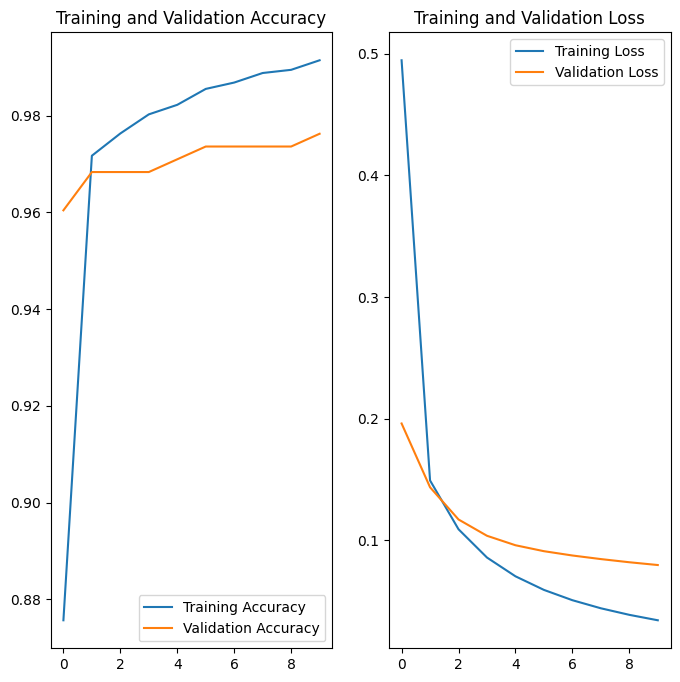

In [52]:
acc = history_TF.history['acc']
val_acc = history_TF.history['val_acc']

loss = history_TF.history['loss']
val_loss = history_TF.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The following code takes the image_batch as input and uses the trained model to predict the class labels. 

In [53]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 0s 424ms/step
['Product_3' 'Product_1' 'Product_5' 'Product_5' 'Product_1' 'Product_5'
 'Product_3' 'Product_1' 'Product_3' 'Product_3' 'Product_3' 'Product_3'
 'Product_1' 'Product_1' 'Product_5' 'Product_1' 'Product_3' 'Product_1'
 'Product_5' 'Product_1' 'Product_4' 'Product_1' 'Product_4' 'Product_4'
 'Product_3' 'Product_5' 'Product_1' 'Product_3' 'Product_1' 'Product_1'
 'Product_1' 'Product_5']


The following code plots a figure showing 30 images from the batch along with their predicted labels

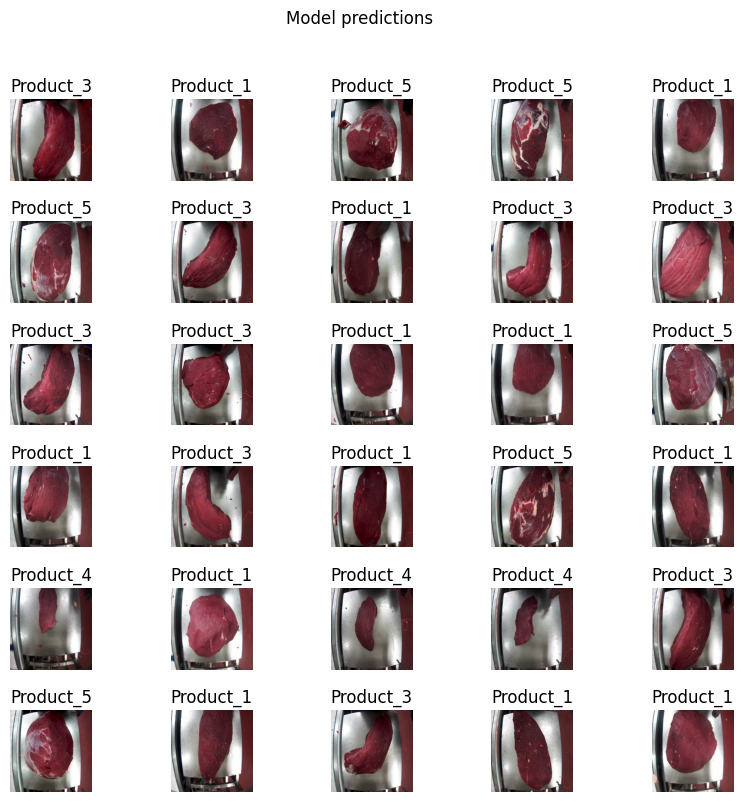

In [54]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

# Comparison between CNN and transfer learning model

The CNN model (augmented one) resulted following accuracies in the last epoch.

training accuracy = 0.9551

validation accuracy = 0.9631

and the transfer learning model resulted following accuracies in the last epoch.

training accuracy = 0.9914  
validation accuracy = 0.9763

Clearly, transfer learning model generated better accuracies when compared to CNN model. 

The following code plots validation and training accuracies of both transfer learning model and CNN into one plot. 

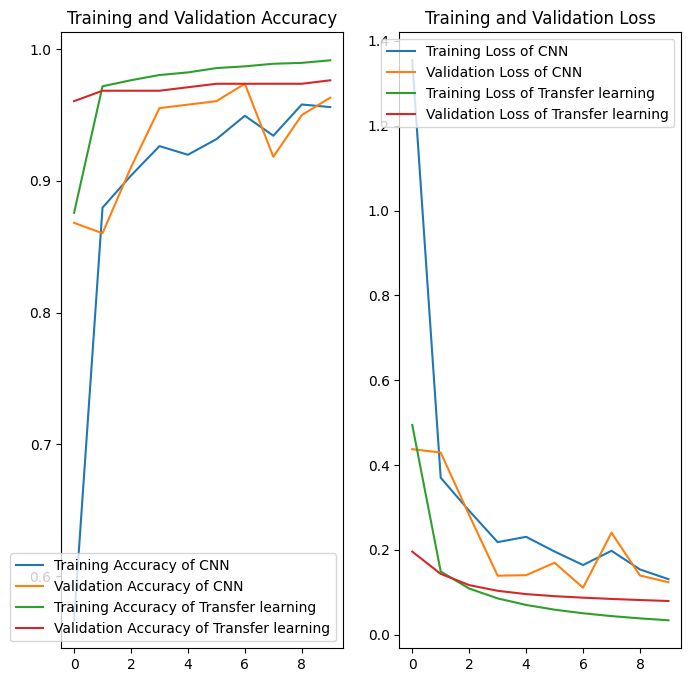

In [55]:

acc_CNN = history_CNN.history['accuracy']
val_acc_CNN = history_CNN.history['val_accuracy']
acc_TF = history_TF.history['acc']
val_acc_TF = history_TF.history['val_acc']

loss_CNN = history_CNN.history['loss']
val_loss_CNN = history_CNN.history['val_loss']
loss_TF = history_TF.history['loss']
val_loss_TF = history_TF.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_CNN, label='Training Accuracy of CNN')
plt.plot(epochs_range, val_acc_CNN, label='Validation Accuracy of CNN')
plt.plot(epochs_range, acc_TF, label='Training Accuracy of Transfer learning')
plt.plot(epochs_range, val_acc_TF, label='Validation Accuracy of Transfer learning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_CNN, label='Training Loss of CNN')
plt.plot(epochs_range, val_loss_CNN, label='Validation Loss of CNN')
plt.plot(epochs_range, loss_TF, label='Training Loss of Transfer learning')
plt.plot(epochs_range, val_loss_TF, label='Validation Loss of Transfer learning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the plot it is clear that the accuracies of Transfer learning is on the higher side as compared to CNN model. Also, loss of Transfer learning are lower. Higher accuracy and lower loss are expected for a better model. Therefore, Transfer learning model is better as compared to CNN in this project. 